### Descripción

link

keyboard_arrow_up

### Contexto de negocios.

Una empresa aseguradora en salud está presentando altos costos dados por complicaciones de pacientes que anteriormente habían sido marcados con ciertas enfermedades, cuya complicación puede aumentar tanto el costo, como la preocupación del paciente. Una de las enfermedades que han decidido estudiar estratégicamente es el Cáncer de Mamá. Dado esto, la empresa requiere mantener un control de estos pacientes, haciendo demanda inducida, seguimiento periódico, adopción de estrategias médicas, entre otras, que permitan evitar que se llegue a alguna complicación. Es necesario priorizar estos pacientes tratando de predecir quiénes llegarán a presentar alguna complicación en los siguientes 6 meses.

### Problema de negocios

La empresa ha decidido contratarlos para que construyan un modelo predictivo que permita estimar la probabilidad de que un paciente diagnosticado con Cáncer de Mama presente una complicación en los próximos 6 meses.

### Contexto analítico

Se espera que entrene diferentes familias de modelos predictivos de clasificación (ver sección siguiente), precedidos por diferentes procesos de transformación (normalizaciones, imputación, ingeniería de características, dummificación, selección de características).

La evaluación de la calidad de los flujos de modelos predictivos se debe estimar utilizando la métrica de F1-Score.

Expliquen sus ideas, el por qué realiza las acciones, y comenten los resultados obtenidos; Se espera mucho más que unos bloques de código.  
La toma de decisiones sobre los datos se debe hacer considerando el contexto del problema y de los datos, no se puede ver todo solamente desde los ojos de los datos, sino también considerar el negocio.  
Un Científico de Datos debe poder comunicar los puntos importantes de su trabajo en un lenguaje universal para todos los públicos.  
Todo esto se considera en la nota.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt



In [2]:
#cargamos el dataset que esta en formato .parquet

df = pd.read_parquet('../Data/df_train.parquet')
#mostramos las primeras filas del dataset
print(df.head())
#mostramos las columnas del dataset
print(df.columns)
#mostramos la forma del dataset
print(df.shape)
#mostramos los tipos de datos del dataset
print(df.dtypes)

     GENERO ESTADO_CIVIL FECHA_NACIMIENTO CODIGO_SEDE MULTI_CANCER CESION  \
ID                                                                          
2987      F           SO       1977-01-17        1051         None      0   
3423      F           CA       1980-10-13        1028         None      0   
6981      F           SO       1951-10-28        1022         None      0   
6701      F           SO       1984-03-31        1026         None      0   
7361      F           UL       1974-03-28        1007         None      0   

      RIESGOS CANCER_MAMA_FAMILIAR CANCER_OTRO_SITIO  \
ID                                                     
2987      2.0                    0                 0   
3423      1.0                    0                 0   
6981      3.0                    0                 0   
6701      1.0                    0                 0   
7361      1.0                    0                 0   

     CANCER_OTRO_SITIO_FAMILIAR  ... radioterapias_cancer  \
ID    

In [3]:
#Revisamos si hay valores nulos en el dataset
print(df.isnull().sum())


GENERO                           0
ESTADO_CIVIL                     0
FECHA_NACIMIENTO                 0
CODIGO_SEDE                      0
MULTI_CANCER                  3618
CESION                           0
RIESGOS                          0
CANCER_MAMA_FAMILIAR             0
CANCER_OTRO_SITIO                0
CANCER_OTRO_SITIO_FAMILIAR       0
CEREBRAL_FAMILIAR                0
FECHA_DATOS_PESO_TALLA           0
PESO                           133
TALLA                          133
FECHA_CONSULTA_TENSION           0
TSISTOLICA                     140
TDIASTOLICA                    140
Fecha_cero                       0
Target                           0
mes_6                            0
mes_5                            0
mes_4                            0
mes_3                            0
mes_2                            0
mes_1                            0
valor_servicio                   0
IV_NIVEL                         0
HOSPI_NO_QUIRURGICA              0
URGENCIAS           

In [4]:
#revisamos los valores unicos de la columna MULTI_CANCER
print(df['MULTI_CANCER'].unique())               

[None '1' '2']


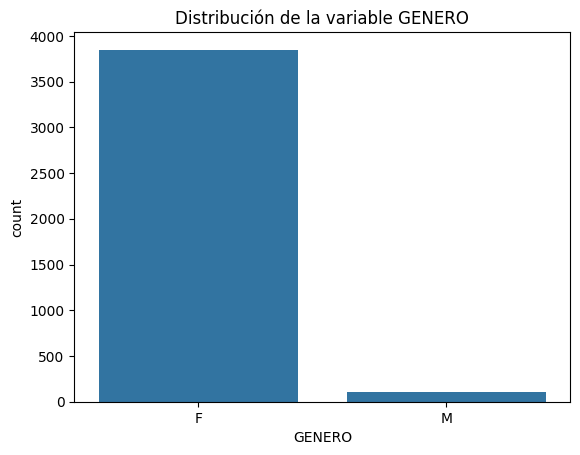

In [5]:
#Analisis univariado de la variable GENERO
sns.countplot(x='GENERO', data=df)
plt.title('Distribución de la variable GENERO')
plt.show()


In [6]:
#contamos cuantos valores unicos hay en la variable genero
print(df['GENERO'].value_counts())


GENERO
F    3848
M     107
Name: count, dtype: int64


- A pesar de que la mayoría son mujeres, el hecho de que haya algunos hombres con cáncer de mama es raro y clínicamente relevante. Podrían tener un comportamiento distinto en cuanto a complicaciones, por ejemplo:

- Diagnóstico más tardío (menos sospecha).

- Acceso diferente a tratamientos.

- Mayor tasa de complicaciones (hipótesis que puedes validar con datos).

- Por tanto, aunque haya pocos hombres, no se deberia eliminar pero si tratar de balancear la Variable

### se propone convertir esta variable en binaria df['GENERO'] = df['GENERO'].map({'Mujer': 0, 'Hombre': 1})



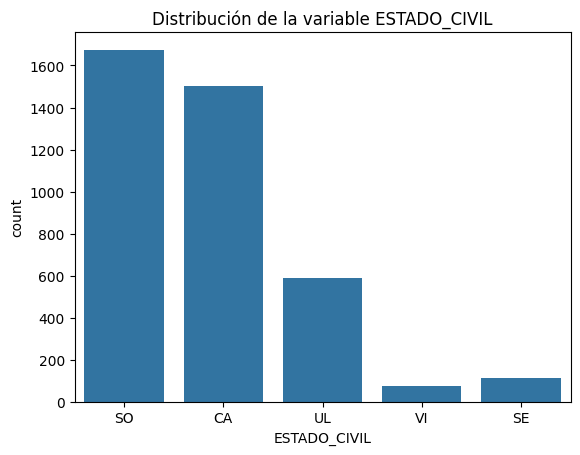

ESTADO_CIVIL
SO    1675
CA    1500
UL     591
SE     113
VI      76
Name: count, dtype: int64


In [7]:
#analizamos la variable ESTADO_CIVIL                     
sns.countplot(x='ESTADO_CIVIL', data=df)
plt.title('Distribución de la variable ESTADO_CIVIL')
plt.show()
#contamos cuantos valores unicos hay en la variable ESTADO_CIVIL
print(df['ESTADO_CIVIL'].value_counts())


##aunque podría tener relación indirecta con red de apoyo, pero suele tener bajo peso predictivo.  segun estudios https://pmc.ncbi.nlm.nih.gov/articles/PMC5419505/#:~:text=Among%20145%2C564%20breast%20cancer%20cases,%E2%80%931.32)%20for%20total%20mortality. al parecer no es relevante para la prediccion, sin embargo se propone convertiral en binaria agrupando SO+VI+SE y CA+UL quye daria como resultado SO o CA 1 o 0

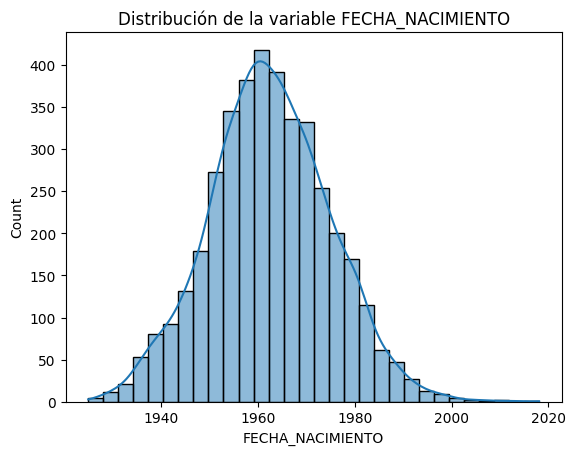

In [8]:
#Analisis univariado de la variable FECHA_NACIMIENTO                 
sns.histplot(df['FECHA_NACIMIENTO'], bins=30, kde=True)
plt.title('Distribución de la variable FECHA_NACIMIENTO')
plt.show()

- Con la FECHA_DE_NACIMIENTO SE PROPONE
- Calcular la edad con respecto a la fecha de complicacion Fecha_cero, en caso de no estar se propone usar la fecha en que se tomo la medicion de talla y peso
- distribuir la edad segun OMS


| Grupo de edad | Edad (aproximada) | Características                                                |
|---------------|-------------------|----------------------------------------------------------------|
| Jóvenes       | < 40 años         | Menos común, pero puede ser más agresivo                       |
| Adultos       | 40-60 años        | La mayoría de los casos se diagnostican en este rango          |
| Ancianos      | > 60 años         | Mayor riesgo de desarrollar cáncer de mama                     |


y luego transformar la variable en booleana usando one hot enconding

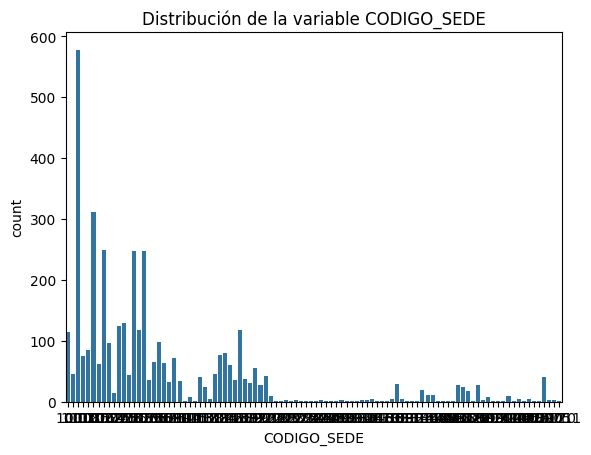

CODIGO_SEDE
1007     578
1015     312
1022     249
1052     248
1059     248
        ... 
20011      1
8022       1
2043       1
4005       1
9014       1
Name: count, Length: 98, dtype: int64


In [9]:
#analizamos la distribucion de la variable CODIGO_SEDE
sns.countplot(x='CODIGO_SEDE', data=df)
plt.title('Distribución de la variable CODIGO_SEDE')
plt.show()
#contamos cuantos valores unicos hay en la variable CODIGO_SEDE
print(df['CODIGO_SEDE'].value_counts())

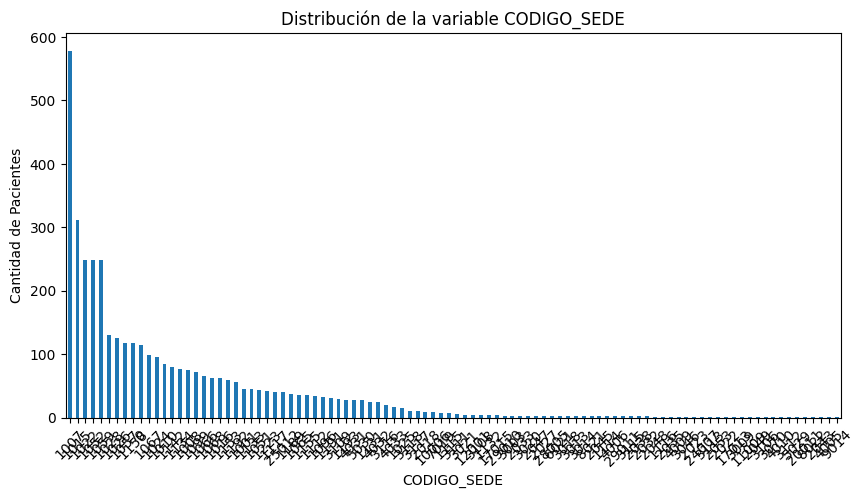

In [10]:
#Revisamos las sedes con mayor cantidad de pacientes en rangos de cantidad 
#de 1000 a 5000, 5000 a 10000, 10000 a 20000, 20000 a 30000, 30000 a 40000, y mayores de 40000  
df['CODIGO_SEDE'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Distribución de la variable CODIGO_SEDE')
plt.xlabel('CODIGO_SEDE')
plt.ylabel('Cantidad de Pacientes')
plt.xticks(rotation=45)
plt.show()




-Para la sede se propone Agrupar esas 10 que tienen mas de 100 pacientes sedes como categorías individuales y todo lo demás como 'OTRAS'

# Paso 1: identificar las top 10 sedes con más pacientes
top_10_sedes = df['CODIGO_SEDE'].value_counts().nlargest(10).index

# Paso 2: crear columna agrupada
df['SEDE_AGRUPADA'] = df['CODIGO_SEDE'].apply(lambda x: x if x in top_10_sedes else 'OTRAS')



C:\Users\rchic\AppData\Local\Temp\ipykernel_18436\2307991738.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MULTI_CANCER'].fillna(0, inplace=True)


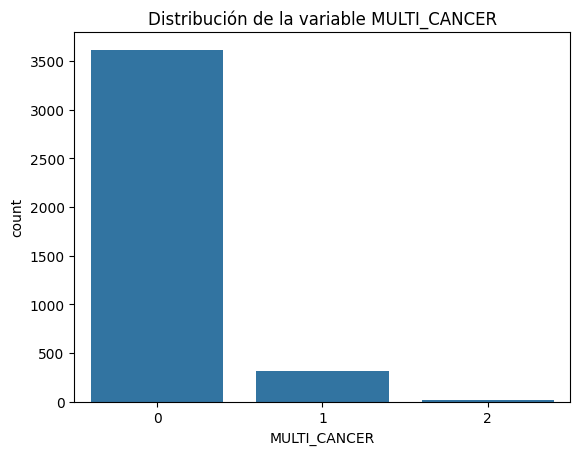

MULTI_CANCER
0    3618
1     317
2      20
Name: count, dtype: int64


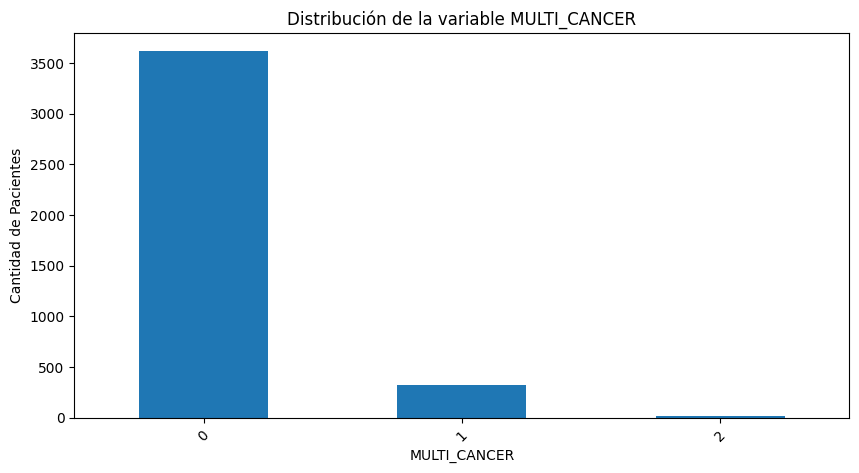

In [11]:
#asignamos 0 a los valores nulos de la variable MULTI_CANCER
df['MULTI_CANCER'].fillna(0, inplace=True)
#analizamos la variable MULTI_CANCER
sns.countplot(x='MULTI_CANCER', data=df)
plt.title('Distribución de la variable MULTI_CANCER')
plt.show()
#contamos cuantos valores unicos hay en la variable MULTI_CANCER
print(df['MULTI_CANCER'].value_counts())
#Revisamos la cantidad de pacientes con MULTI_CANCER = 1 y MULTI_CANCER = 0
df['MULTI_CANCER'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Distribución de la variable MULTI_CANCER')
plt.xlabel('MULTI_CANCER')
plt.ylabel('Cantidad de Pacientes')
plt.xticks(rotation=45)
plt.show()

- Dado que el 2 es muy poco frecuente (solo 20 casos), podemos agrupar 1 y 2 en una sola categoría de "Tiene otro(s) cáncer(es)" 
df['MULTI_CANCER_BIN'] = df['MULTI_CANCER'].apply(lambda x: 1 if x > 0 else 0)


C:\Users\rchic\AppData\Local\Temp\ipykernel_18436\1200534567.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CESION'].fillna(0, inplace=True)


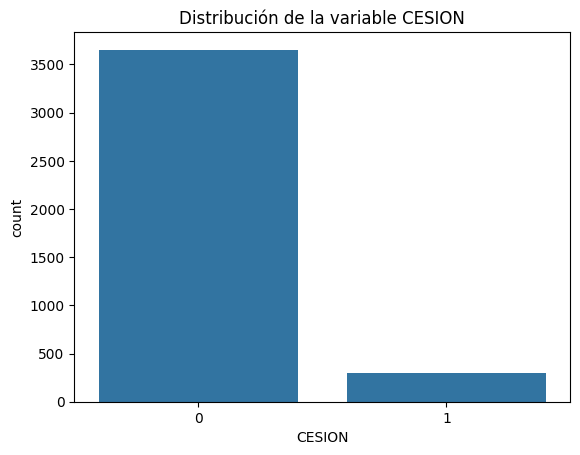

CESION
0    3653
1     302
Name: count, dtype: int64


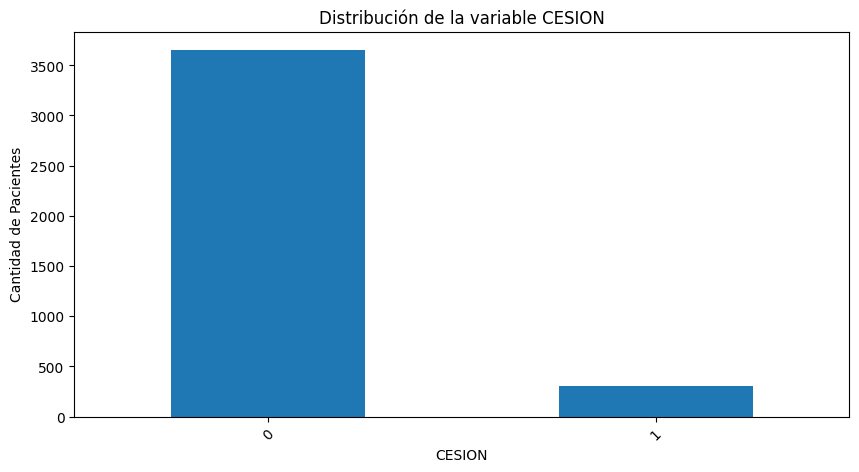

In [12]:
#ANALIZAMOS LA VARIABLE CESION
#asignamos 0 a los valores nulos de la variable CESION
df['CESION'].fillna(0, inplace=True)
#analizamos la variable CESION
sns.countplot(x='CESION', data=df)
plt.title('Distribución de la variable CESION')
plt.show()
#contamos cuantos valores unicos hay en la variable CESION
print(df['CESION'].value_counts())
#Revisamos la cantidad de pacientes con CESION = 1 y CESION = 0
df['CESION'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Distribución de la variable CESION')
plt.xlabel('CESION')
plt.ylabel('Cantidad de Pacientes')
plt.xticks(rotation=45)
plt.show()

-Puede influir en el riesgo de complicación:

Usuarios cedidos a veces llegan con:

 - Diagnósticos más avanzados o tardíos.

 - Tratamientos interrumpidos o cambiados.

 - Historial clínico incompleto.

Transición entre aseguradoras puede generar problemas como:

 - Pérdida de continuidad en atención.

 - Dificultades en autorizaciones o agendamientos.

Todo eso puede afectar la probabilidad de complicación en los próximos 6 meses, que es justo nuestro target.

recomendamos solo imputar los valores nulos a 0

RIESGOS
1.0    1708
2.0     801
0.0     686
3.0     453
4.0     206
5.0      75
6.0      12
7.0      12
8.0       2
Name: count, dtype: int64


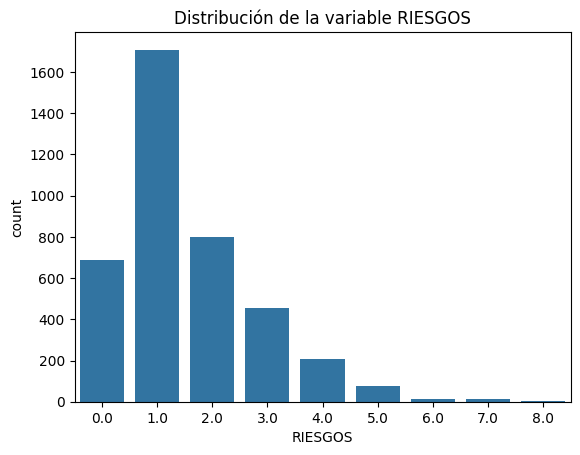

RIESGOS
1.0    1708
2.0     801
0.0     686
3.0     453
4.0     206
5.0      75
6.0      12
7.0      12
8.0       2
Name: count, dtype: int64


In [ ]:
#realizamos el analisis de la variable RIESGOS  

#valuecounts de la variable RIESGOS
print(df['RIESGOS'].value_counts())
#analizamos la variable RIESGOS
sns.countplot(x='RIESGOS', data=df)
plt.title('Distribución de la variable RIESGOS')
plt.show()
#contamos cuantos valores unicos hay en la variable RIESGOS
print(df['RIESGOS'].value_counts())


-El 80% de los pacientes tiene entre 0 y 4 riesgos.

- Hay muy pocos casos con valores 5, 6, 7 y 8, lo que puede generar ruido.
- Agrupar todos los valores mayores a 4 como '5+'

df['RIESGOS_CAP'] = df['RIESGOS'].apply(lambda x: x if x <= 4 else 5)


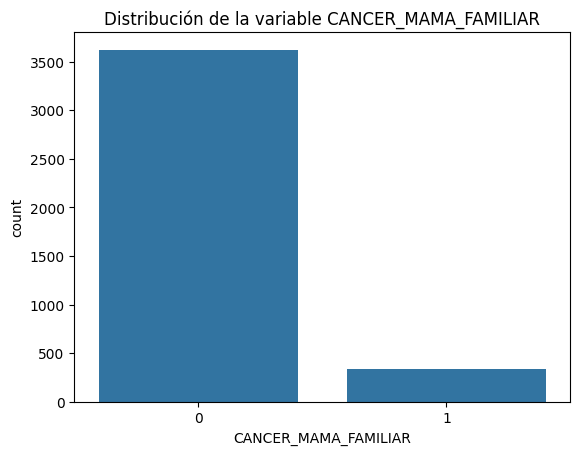

CANCER_MAMA_FAMILIAR
0    3622
1     333
Name: count, dtype: int64


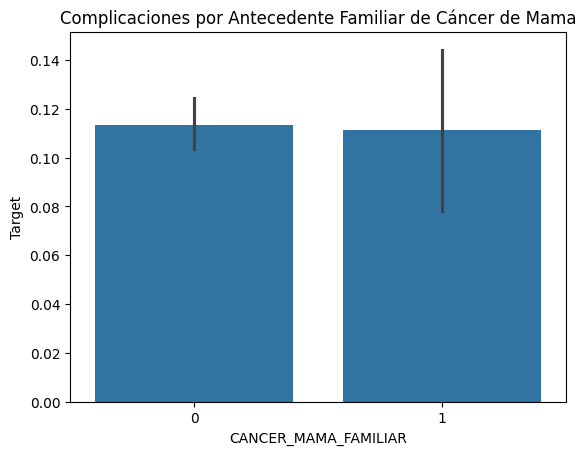

In [17]:
#CANCER_MAMA_FAMILIAR
#analizamos la variable CANCER_MAMA_FAMILIAR
sns.countplot(x='CANCER_MAMA_FAMILIAR', data=df)
plt.title('Distribución de la variable CANCER_MAMA_FAMILIAR')
plt.show()
#contamos cuantos valores unicos hay en la variable CANCER_MAMA_FAMILIAR
print(df['CANCER_MAMA_FAMILIAR'].value_counts())
df.groupby('CANCER_MAMA_FAMILIAR')['Target'].mean()
sns.barplot(x='CANCER_MAMA_FAMILIAR', y='Target', data=df)
plt.title('Complicaciones por Antecedente Familiar de Cáncer de Mama')
plt.show()


Aunque solo el 8.4% de los pacientes tienen antecedentes familiares, esa información puede ser predictiva en modelos clínicos, ya que:

El antecedente familiar es un factor de riesgo importante.

Puede estar relacionado con mutaciones genéticas (ej: BRCA1, BRCA2), lo que puede implicar un mayor riesgo de complicación o aparición de múltiples tumores.

Incluso puede estar asociado con vigilancia médica más intensiva, lo que afecta la forma en que se identifican y tratan las complicaciones.

es clínicamente relevante, en el conjunto de datos no parece tener una asociación fuerte con el riesgo de complicación en los siguientes 6 meses. puede ser utiol combinada con otras variables como MULTI_CANCER, CANCER_OTRO_SITIO_FAMILIAR se recomienda dejarla como esta No es ruidosa, está bien codificada y podría aportar valor combinado.



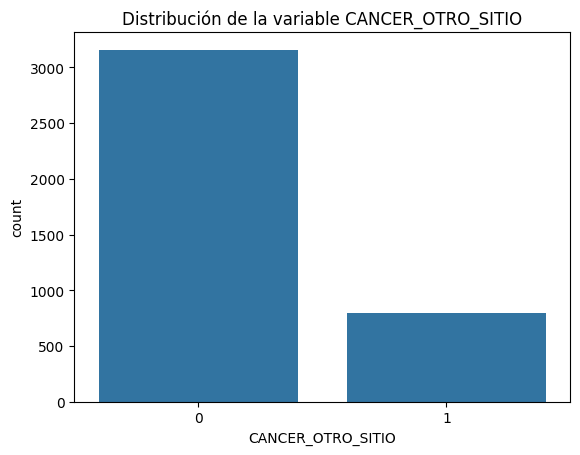

CANCER_OTRO_SITIO
0    3159
1     796
Name: count, dtype: int64


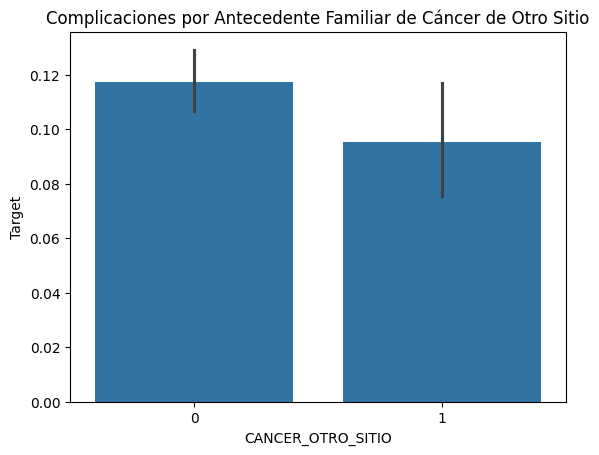

CANCER_OTRO_SITIO
0    0.117442
1    0.095477
Name: Target, dtype: float64

In [19]:
#CANCER_OTRO_SITIO
#analizamos la variable CANCER_OTRO_SITIO
sns.countplot(x='CANCER_OTRO_SITIO', data=df)
plt.title('Distribución de la variable CANCER_OTRO_SITIO')
plt.show()
#contamos cuantos valores unicos hay en la variable CANCER_OTRO_SITIO
print(df['CANCER_OTRO_SITIO'].value_counts())
df.groupby('CANCER_OTRO_SITIO')['Target'].mean()
sns.barplot(x='CANCER_OTRO_SITIO', y='Target', data=df)
plt.title('Complicaciones por Antecedente Familiar de Cáncer de Otro Sitio')
plt.show()
df.groupby('CANCER_OTRO_SITIO')['Target'].mean()


- Recomendacion Conservar la variable tal como esta

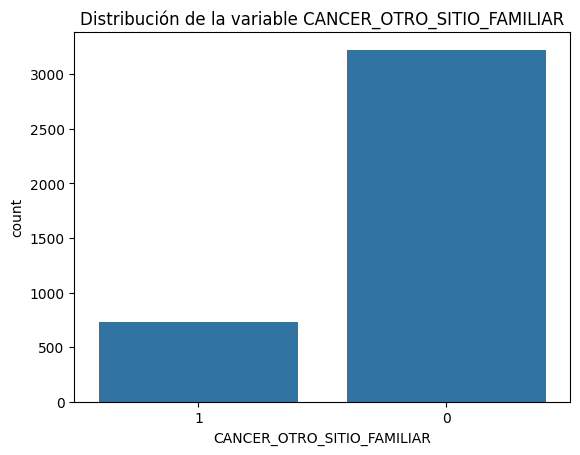

CANCER_OTRO_SITIO_FAMILIAR
0    3225
1     730
Name: count, dtype: int64


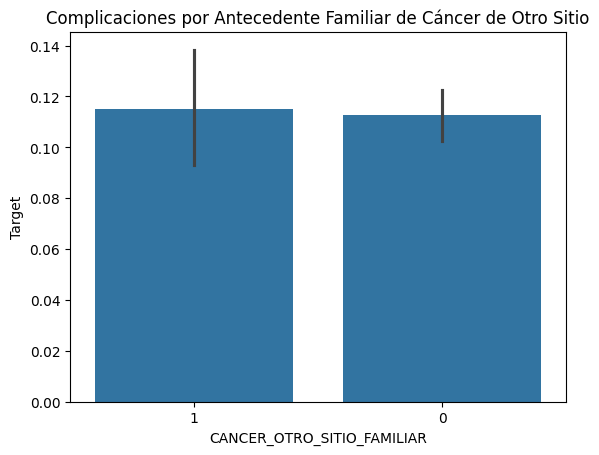

CANCER_OTRO_SITIO_FAMILIAR
0    0.112558
1    0.115068
Name: Target, dtype: float64

In [20]:
#CANCER_OTRO_SITIO_FAMILIAR
#analizamos la variable CANCER_OTRO_SITIO_FAMILIAR
sns.countplot(x='CANCER_OTRO_SITIO_FAMILIAR', data=df)
plt.title('Distribución de la variable CANCER_OTRO_SITIO_FAMILIAR')
plt.show()
#contamos cuantos valores unicos hay en la variable CANCER_OTRO_SITIO_FAMILIAR
print(df['CANCER_OTRO_SITIO_FAMILIAR'].value_counts())
df.groupby('CANCER_OTRO_SITIO_FAMILIAR')['Target'].mean()
sns.barplot(x='CANCER_OTRO_SITIO_FAMILIAR', y='Target', data=df)
plt.title('Complicaciones por Antecedente Familiar de Cáncer de Otro Sitio')
plt.show()
df.groupby('CANCER_OTRO_SITIO_FAMILIAR')['Target'].mean()

- Conservamos la variables tal como esta

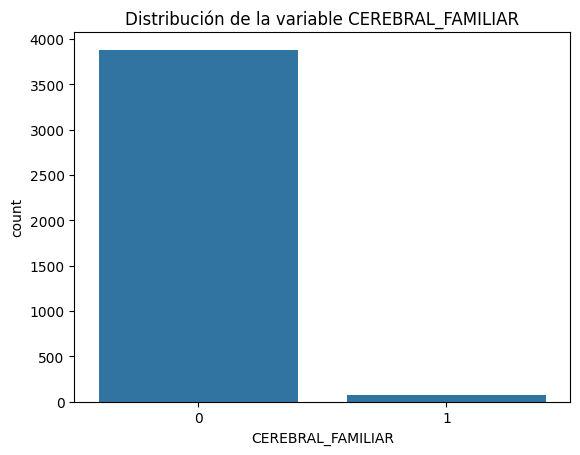

CEREBRAL_FAMILIAR
0    3882
1      73
Name: count, dtype: int64


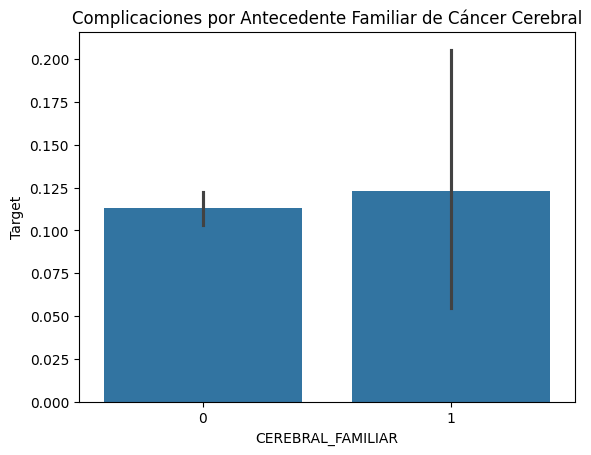

CEREBRAL_FAMILIAR
0    0.112828
1    0.123288
Name: Target, dtype: float64

In [21]:
#CEREBRAL_FAMILIAR
#analizamos la variable CEREBRAL_FAMILIAR
sns.countplot(x='CEREBRAL_FAMILIAR', data=df)
plt.title('Distribución de la variable CEREBRAL_FAMILIAR')
plt.show()
#contamos cuantos valores unicos hay en la variable CEREBRAL_FAMILIAR
print(df['CEREBRAL_FAMILIAR'].value_counts())
df.groupby('CEREBRAL_FAMILIAR')['Target'].mean()
sns.barplot(x='CEREBRAL_FAMILIAR', y='Target', data=df)
plt.title('Complicaciones por Antecedente Familiar de Cáncer Cerebral')
plt.show()
df.groupby('CEREBRAL_FAMILIAR')['Target'].mean()

-Dejamos como esta la variable

## Analisis de las variables CANCER_MAMA_FAMILIAR , CANCER_OTRO_SITIO,  CANCER_OTRO_SITIO_FAMILIAR, CEREBRAL_FAMILIAR

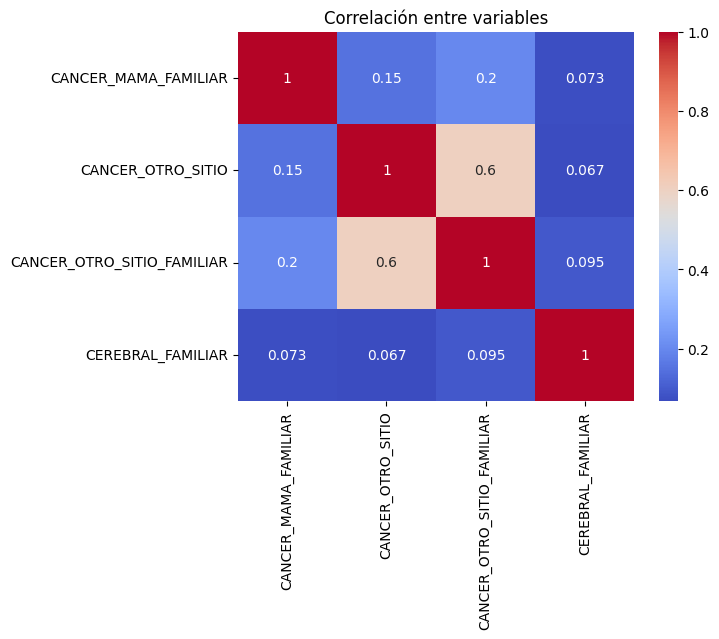

In [22]:
#validamos si existe colinealidad entre las variables CANCER_MAMA_FAMILIAR CANCER_OTRO_SITIO CANCER_OTRO_SITIO_FAMILIAR CEREBRAL_FAMILIAR
df[['CANCER_MAMA_FAMILIAR', 'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 'CEREBRAL_FAMILIAR']].corr()
#analizamos la variable CANCER_MAMA_FAMILIAR
sns.heatmap(df[['CANCER_MAMA_FAMILIAR', 'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 'CEREBRAL_FAMILIAR']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlación entre variables')
plt.show()


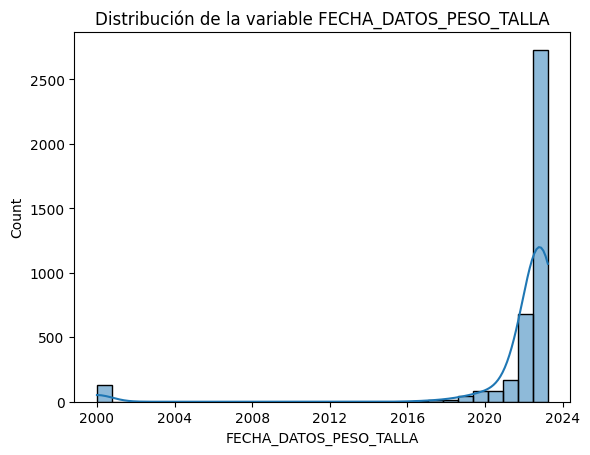

In [27]:
#FECHA_DATOS_PESO_TALLA
#analizamos la variable FECHA_DATOS_PESO_TALLA
sns.histplot(df['FECHA_DATOS_PESO_TALLA'], bins=30, kde=True)
plt.title('Distribución de la variable FECHA_DATOS_PESO_TALLA')
plt.show()




#con la fecha  de datos peso y talla creamos una nueva variable DIAS_ULTIMO_CONTROL que es el tiempo en dias desde la fecha cero esto no indica siel paciente tuvo un control frecuente o no 
df['DIAS_ULTIMO_CONTROL'] = (pd.to_datetime(df['Fecha_cero']) - pd.to_datetime(df['FECHA_DATOS_PESO_TALLA'])).dt.days


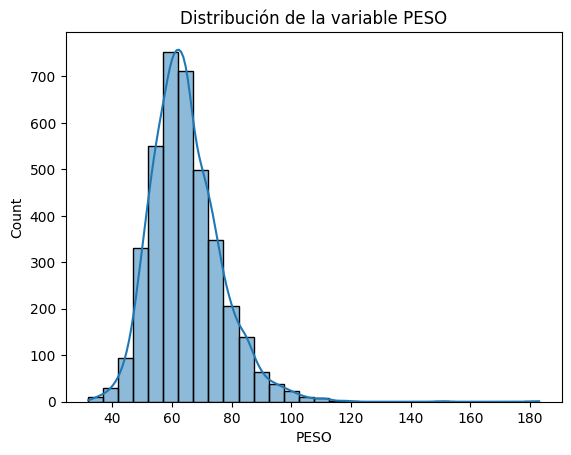

In [30]:
#PESO
#analizamos la variable PESO
sns.histplot(df['PESO'], bins=30, kde=True)
plt.title('Distribución de la variable PESO')
plt.show()


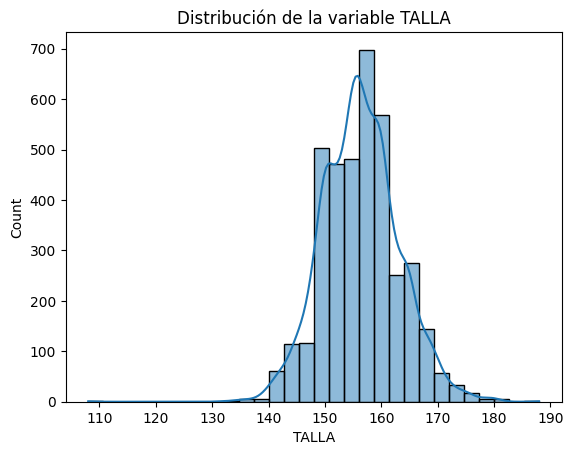

In [31]:
#TALLA
#analizamos la variable TALLA
sns.histplot(df['TALLA'], bins=30, kde=True)
plt.title('Distribución de la variable TALLA')
plt.show()


- Con las variables PESO y TALLA se propone crear una nueva variable IMC 

| IMC            | Nivel de peso |
|-----------------|---------------|
| Por debajo de 18.5 | Bajo peso |
| 18.5 – 24.9    | Normal        |
| 25.0 – 29.9    | Sobrepeso     |
| 30.0 o más     | Obesidad      |


- posterior a eso codificar la variable usando one-hot

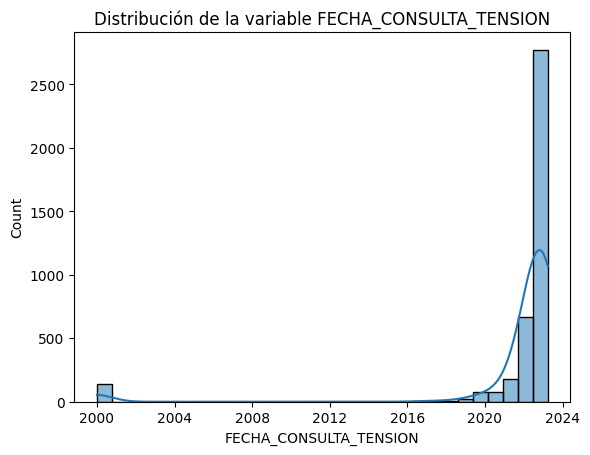

¿Todas las fechas son iguales?: False
El 64.80% de las fechas son iguales


In [34]:
#FECHA_CONSULTA_TENSION
#analizamos la variable FECHA_CONSULTA_TENSION
sns.histplot(df['FECHA_CONSULTA_TENSION'], bins=30, kde=True)
plt.title('Distribución de la variable FECHA_CONSULTA_TENSION')
plt.show()
# Validamos si FECHA_CONSULTA_TENSION y FECHA_DATOS_PESO_TALLA tienen los mismos valores
same_dates = (df['FECHA_CONSULTA_TENSION'] == df['FECHA_DATOS_PESO_TALLA']).all()
print(f"¿Todas las fechas son iguales?: {same_dates}")
#que % de las fechas son iguales
same_dates_percentage = (df['FECHA_CONSULTA_TENSION'] == df['FECHA_DATOS_PESO_TALLA']).mean() * 100
print(f"El {same_dates_percentage:.2f}% de las fechas son iguales")



#con la FECHA_CONSULTA_TENSION creamos una nueva variable DIAS_ULTIMO_CONTROL que es el tiempo en dias desde la fecha cero esto no indica si el paciente tuvo un control frecuente o no 
df['DIAS_ULTIMO_CONTROL_2'] = (pd.to_datetime(df['Fecha_cero']) - pd.to_datetime(df['FECHA_CONSULTA_TENSION'])).dt.days

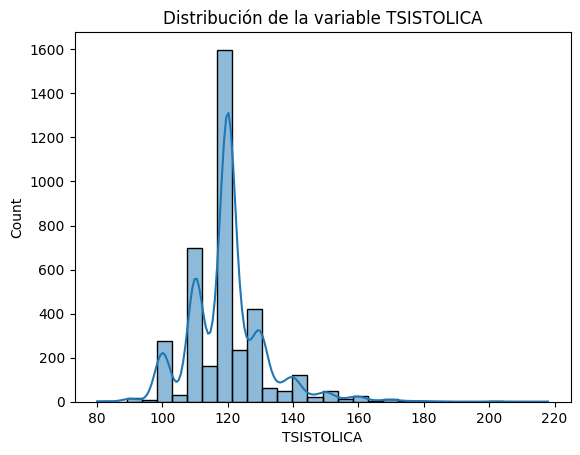

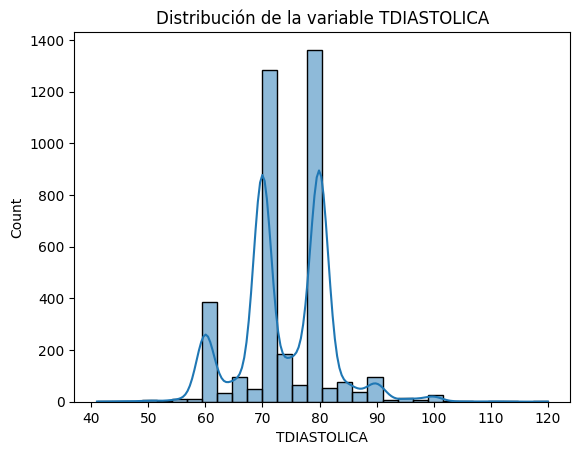

In [ ]:
#TSISTOLICA TDIASTOLICA
#analizamos la variable TSISTOLICA
sns.histplot(df['TSISTOLICA'], bins=30, kde=True)
plt.title('Distribución de la variable TSISTOLICA')
plt.show()
#analizamos la variable TDIASTOLICA
sns.histplot(df['TDIASTOLICA'], bins=30, kde=True)
plt.title('Distribución de la variable TDIASTOLICA')
plt.show()




Se propone calcular una nueva variable TENSION, que se clasifique la tension arterial del paciente segun la OMS
| Categoría         | Presión arterial sistólica (PAs) | Presión arterial diastólica (PAd) |
|-------------------|----------------------------------|-----------------------------------|
| Óptima            | <120 mmHg                       | <80 mmHg                         |
| Normal            | <130 mmHg                       | <85 mmHg                         |
| Normal-alta       | 130-139 mmHg                    | 85-89 mmHg                       |
| Hipertensión I    | 140-159 mmHg                    | 90-99 mmHg                       |
| Hipertensión II   | 160-179 mmHg                    | 100-109 mmHg                     |
| Hipertensión III  | 180 mmHg o más                  | 110 mmHg o más                   |

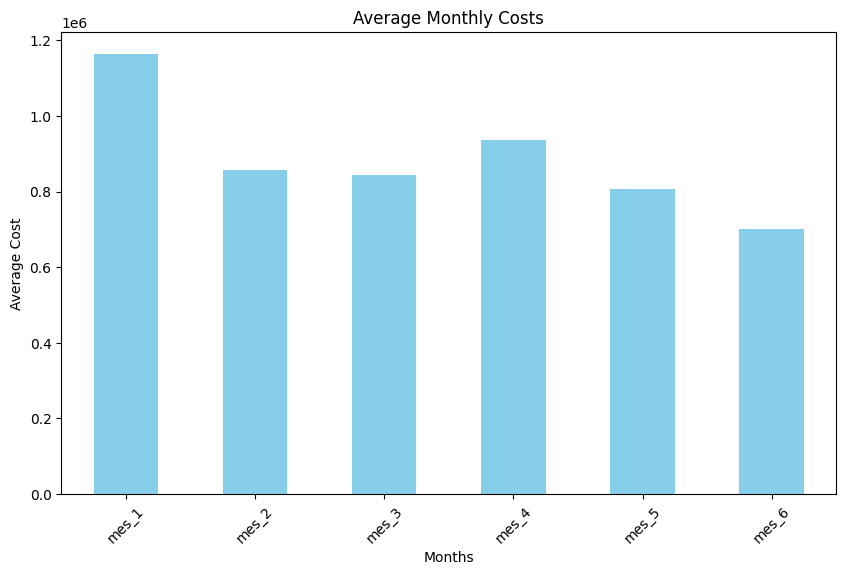

Percentage change in costs month by month:
mes_1          NaN
mes_2   -26.350729
mes_3    -1.435314
mes_4    10.721276
mes_5   -13.840765
mes_6   -13.157226
dtype: float64


In [37]:
# Visualizing the monthly costs
monthly_columns = ['mes_1', 'mes_2', 'mes_3', 'mes_4', 'mes_5', 'mes_6']
df[monthly_columns].mean().plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Average Monthly Costs')
plt.xlabel('Months')
plt.ylabel('Average Cost')
plt.xticks(rotation=45)
plt.show()

# Calculating the percentage change in costs month by month
monthly_means = df[monthly_columns].mean()
percentage_change = monthly_means.pct_change() * 100
print("Percentage change in costs month by month:")
print(percentage_change)

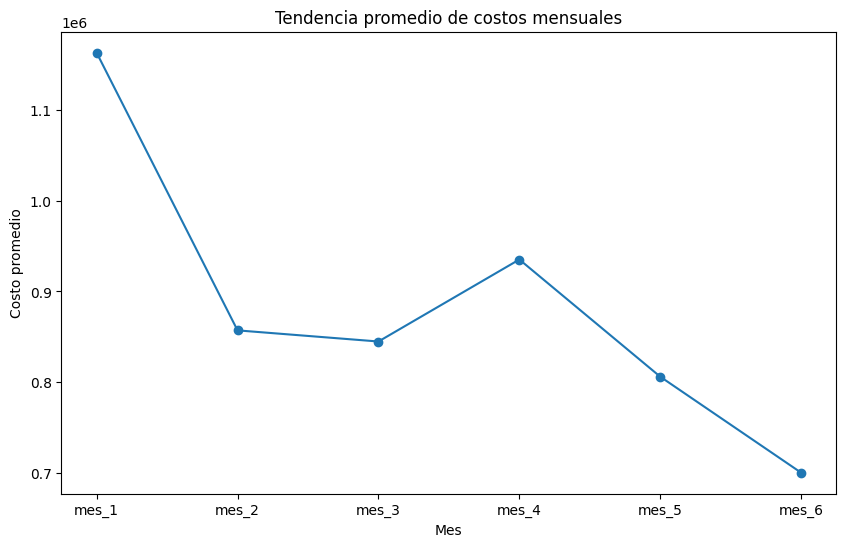

In [38]:
df[['mes_1', 'mes_2', 'mes_3', 'mes_4', 'mes_5', 'mes_6']].mean().plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Tendencia promedio de costos mensuales')
plt.xlabel('Mes')
plt.ylabel('Costo promedio')
plt.show()

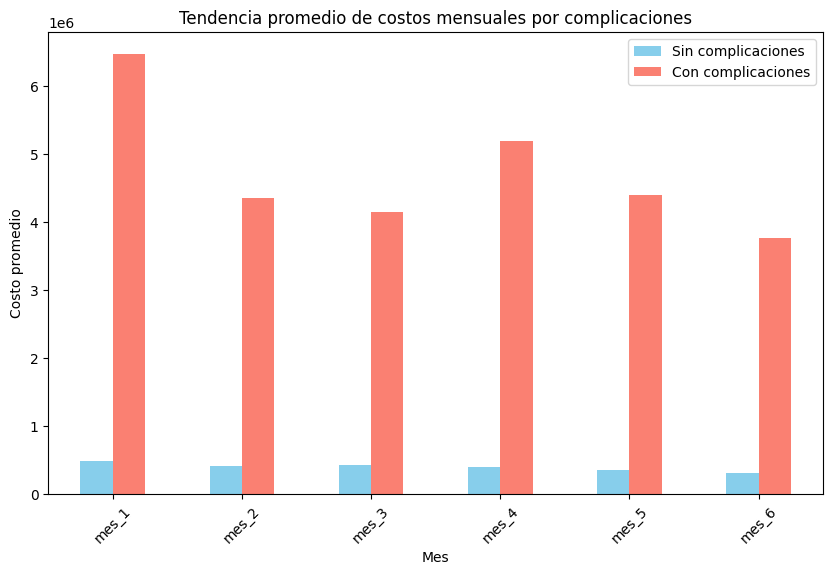

In [39]:
#enonctramos la tendencia de costos mensuales para pacientes con y sin complicaciones
df.groupby('Target')[monthly_columns].mean().T.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'salmon'])   
plt.title('Tendencia promedio de costos mensuales por complicaciones')
plt.xlabel('Mes')
plt.ylabel('Costo promedio')
plt.xticks(rotation=45)
plt.legend(['Sin complicaciones', 'Con complicaciones'])
plt.show()

- con referencia a los costos podemos observar que lops pacientes que tuvieron complicaciones a los seis meses tuvieron costos de atencion altos en los 6 meses anteriores
- con esta referencia podemos usar los costos totales para clasificar los pacientes en bajo, alto y convertir esa variable en binaria
